In [1]:
import anndata as ad
import scanpy as sc
extract_dir = "data/"
adata = ad.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad') # ad.read_h5ad()
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

In [2]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

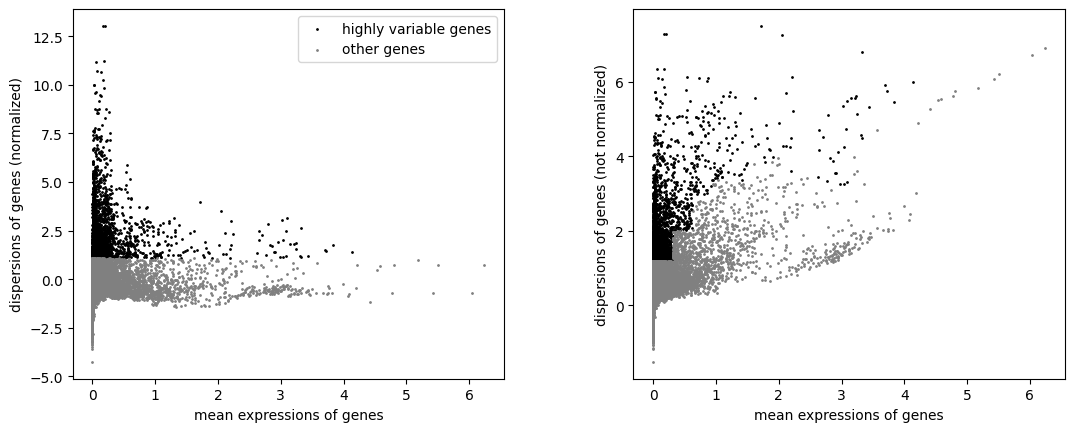

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2300)
sc.pl.highly_variable_genes(adata)

# Clustering

In [4]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver = 'arpack')

In [5]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, random_state=42)

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=46, random_state=42)
adata.obs['kmeans'] = kmeans.fit_predict(adata.obsm['X_pca']).astype(str)

/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/backend/context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 20] Not a directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/backend/context.py", line 249, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_darwin()
  File "/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/backend/context.py", line 312, in _count_physical_cores_darwin
    cpu_info = subprocess.run(
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/Library/Developer/CommandLine

In [15]:
sc.tl.louvain(adata, resolution=1.35, key_added="louvain")

In [13]:
sc.tl.leiden(adata, resolution=1.0, key_added="leiden")

In [9]:
sc.tl.umap(adata, min_dist=0.3, random_state=42)

In [10]:
import matplotlib.pyplot as plt
def visualize_cluster(adata, tag='', is_show=False):
    cluster_types = ["louvain", "leiden", "kmeans", "cluster"]
    titles = ["UMAP - Louvain Clusters", "UMAP - Leiden Clusters", 
              "UMAP - KMeans Clusters", "UMAP - True Clusters"]

    for cluster_type, title in zip(cluster_types, titles):
        sc.pl.umap(
            adata, color=cluster_type,
            title=title,
            legend_loc="right margin",
            size=10,
            alpha=0.7,
            frameon=False,
            show=is_show # 确保不直接显示，以便可以保存
        )
        if is_show:
            plt.show()
        else:
            plt.savefig(f"results/cluster_{cluster_type}_{tag}.png", bbox_inches='tight', dpi=300)
            plt.close() 

In [19]:
visualize_cluster(adata, is_show=False)

In [17]:
from sklearn.metrics import adjusted_rand_score, rand_score, silhouette_score, calinski_harabasz_score
def eval_cluster(adata, methods=["louvain", "leiden", "kmeans"]):
  if "cluster" in adata.obs.columns:
      true_labels = adata.obs["cluster"].astype(str)

      for method in methods:
          pred_labels = adata.obs[method]
          ari = adjusted_rand_score(true_labels, pred_labels)
          ri = rand_score(true_labels, pred_labels)
          sil = silhouette_score(adata.obsm["X_pca"], pred_labels.astype(int))
          ch = calinski_harabasz_score(adata.obsm["X_pca"], pred_labels.astype(int))
          print(f"=== {method.upper()} Clustering Metrics ===")
          print(f"Adjusted Rand Index (ARI): {ari:.3f}")
          print(f"Rand Index: {ri:.3f}")
          print(f"Silhouette Score: {sil:.3f}")
          print(f"Calinski-Harabasz Index: {ch:.3f}\n")
  else:
      print("False ground truth，only calculate silhouette, CH index")

In [18]:
eval_cluster(adata)

=== LOUVAIN Clustering Metrics ===
Adjusted Rand Index (ARI): 0.437
Rand Index: 0.922
Silhouette Score: 0.196
Calinski-Harabasz Index: 1023.231

=== LEIDEN Clustering Metrics ===
Adjusted Rand Index (ARI): 0.459
Rand Index: 0.924
Silhouette Score: 0.210
Calinski-Harabasz Index: 1004.550

=== KMEANS Clustering Metrics ===
Adjusted Rand Index (ARI): 0.481
Rand Index: 0.879
Silhouette Score: 0.504
Calinski-Harabasz Index: 1859.406



# Gene Marker

In [20]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from functools import reduce
from collections import defaultdict, Counter

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120)

In [21]:
import os
extract_dir = "data/"
supp_table_path = os.path.join(extract_dir, "aav9996_tables3.xlsx")
output_dir = extract_dir+"results"
os.makedirs(output_dir, exist_ok=True)

In [22]:
def load_supp_table_3(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No file: {filepath}")

    df = pd.read_excel(filepath, sheet_name='ROC markers', header=None)
    genes = df.iloc[:, 0].dropna().astype(str).str.strip().tolist()
    genes = [g for g in genes if g != 'nan']
    print(f"# of genes in Supplementary Table 3: {len(genes)} ")
    gene_set = set(genes)
    print(f"# of unique genes in Supplementary Table 3: {len(gene_set)} ")
    return gene_set

def find_marker_genes(adata, groupby='cluster', methods=['logreg', 'wilcoxon'], n_markers=100):
    target_cluster = 'ROCs'
    results = {}

    for method in methods:
        print(f"Finding markers for '{target_cluster}' using {method}...")
        sc.tl.rank_genes_groups(
            adata, groupby=groupby, method=method,
            key_added=f'rank_genes_{method}'
        )
        df = sc.get.rank_genes_groups_df(adata, group=target_cluster, key=f'rank_genes_{method}')
        df['abs_score'] = df['scores'].abs()
        top_genes = df.nlargest(n_markers, 'abs_score')['names'].tolist()
        results[method] = {target_cluster: set(top_genes)}

    print("Finished!")
    return results

In [23]:
supp_genes = load_supp_table_3(supp_table_path)

# of genes in Supplementary Table 3: 50 
# of unique genes in Supplementary Table 3: 45 


In [24]:
marker_results_true = find_marker_genes(adata, groupby='cluster', methods=['logreg', 'wilcoxon'], n_markers=100)

Finding markers for 'ROCs' using logreg...
ranking genes
    finished (0:00:42)
Finding markers for 'ROCs' using wilcoxon...
ranking genes


/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchange

    finished (0:02:12)
Finished!


In [25]:
def clean_gene_names(results):
    cleaned_results = {}
    
    for method, clusters in results.items():
        cleaned_clusters = {}
        for cluster, gene_set in clusters.items():
            cleaned_genes = {gene.split('.')[0] for gene in gene_set if isinstance(gene, str)}
            cleaned_clusters[cluster] = cleaned_genes
        cleaned_results[method] = cleaned_clusters
    
    return cleaned_results

marker_results_true_clean = clean_gene_names(marker_results_true)
print(marker_results_true_clean)

{'logreg': {'ROCs': {'tmem82', 'loc100488471', 'krt16', 'loc100497282', 'Xelaev18026267m', 'gdf6', 'mxra5', 'Xelaev18020334m', 'lef1', 'ptgs1', 'fgf9', 'Xelaev18044182m', 'optc', 'Xelaev18028101m', 'fstl1', 'fgf7', 'sp9', 'krt8', 'pzp', 'fbn2', 'eva1b', 'lama1', 'pltp', 'emx1', 'egfl6', 'Xelaev18043716m', 'tgfb1', 'acvr1', 'Xelaev18011091m', 'Xelaev18028564m', 'loc101732555', 'bmp2', 'tcn2', 'dlx2', 'Xelaev18036901m', 'nid2', 'arhgap22', 'loc495244', 'adamts20', 'Xelaev18043634m', 'Xelaev18043128m', 'kif26a', 'Xelaev18005062m', 'cpa6', 'rhou', 'stk32a', 'sema3f', 'lpar3', 'apoc1', 'Xelaev18004450m', 'loc100036800', 'loc100127750', 'vwde', 'mmp3', 'krt6', 'loc100486548', 'Xetrov90020904m', 'Xelaev18027412m', 'npff', 'fn1', 'Xelaev18009361m', 'wnt5a', 'Xetrov90029035m', 'cyp26c1', 'efemp2', 'loc100493797', 'loc100494738', 'Xelaev18035519m', 'lama5', 'snai2', 'Xetrov90028158m', 'loc100490088', 'Xelaev18007571m', 'unc5b', 'Xelaev18030545m', 'rdh10', 'Xelaev18005859m', 'Xelaev18044969m', 't

In [26]:
def compare_markers_with_supp(marker_results, supp_genes, output_dir=".", tag=""):
    cluster = 'ROCs'  
    methods = list(marker_results.keys())

    method_markers = {}
    for method in methods:
        method_markers[method] = marker_results[method].get(cluster, set())

    venn_data = {method: method_markers[method] for method in methods}
    global_inter = reduce(set.intersection, [method_markers[method] for method in methods])
    global_inter_supp = global_inter & supp_genes
    comparison_data = []
    row = {'cluster': cluster}
    found_any = False

    for method in methods:
        markers = method_markers[method]
        overlap = markers & supp_genes
        row[f"{method}_n_markers"] = len(markers)
        row[f"{method}_in_supp"] = len(overlap)
        row[f"{method}_genes_in_supp"] = ", ".join(sorted(overlap))
        if overlap:
            found_any = True
    inter_with_supp = global_inter & supp_genes
    row['intersection_n'] = len(global_inter)
    row['intersection_in_supp'] = len(inter_with_supp)
    row['intersection_genes_in_supp'] = ", ".join(sorted(inter_with_supp))

    if found_any:
        comparison_data.append(row)

    comp_df = pd.DataFrame(comparison_data)
    csv_path = os.path.join(output_dir, f"marker_comparison_with_supp_{tag}.csv")
    comp_df.to_csv(csv_path, index=False)
    print(f"Results saved: {csv_path}")
    print(f"Common marker genes: {len(global_inter)}")
    print(f"In Supp Table 3: {len(global_inter_supp)} → {sorted(global_inter_supp)}")

    return global_inter, comp_df, venn_data

In [27]:
global_inter, comp_df, venn_data = compare_markers_with_supp(marker_results_true_clean, supp_genes, output_dir)

Results saved: data/results/marker_comparison_with_supp_.csv
Common marker genes: 25
In Supp Table 3: 6 → ['egfl6', 'frem2', 'lpar3', 'nid2', 'pltp', 'vwde']


In [47]:
list(global_inter)

['pltp',
 'loc100490088',
 'egfl6',
 'lpar3',
 'apoc1',
 'Xelaev18026267m',
 'bmp2',
 'vwde',
 'mmp3',
 'mxra5',
 'loc100486548',
 'ptgs1',
 'bmp4',
 'fn1',
 'frem2',
 'optc',
 'nid2',
 'Xetrov90029035m',
 'fras1',
 'fstl1',
 'col14a1',
 'efemp2',
 'krt8',
 'lama5',
 'lama1']

In [95]:
def plot_marker_heatmap(adata, target_genes, groupby='cluster', title="Expression of ROC marker genes"):
    all_marker_genes = marker_results_true['logreg']['ROCs'] | marker_results_true['wilcoxon']['ROCs']
    root_to_original = {gene.split('.')[0]: gene for gene in all_marker_genes}
    mask = np.array([gene in root_to_original for gene in target_genes])
    supp_genes = [root_to_original[target_genes[i]] for i, m in enumerate(mask) if m]

    sc.settings.figdir = 'results'  # 保存路径
    sc.settings.set_figure_params(dpi=150, figsize=(8, 6), format='png')
    adata_rocs = adata[adata.obs['cluster'] == 'ROCs']

    ax = sc.pl.heatmap(
        adata_rocs,
        groupby='cluster',
        var_names=supp_genes,               
        cmap='viridis',                   
        standard_scale='var',           
        dendrogram=False,               
        swap_axes=False,             
        show=False        
    )

    output_path = f"results/heatmap_com_genes.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"Heatmap saved to {output_path}")

Heatmap saved to results/heatmap_supp_genes.png


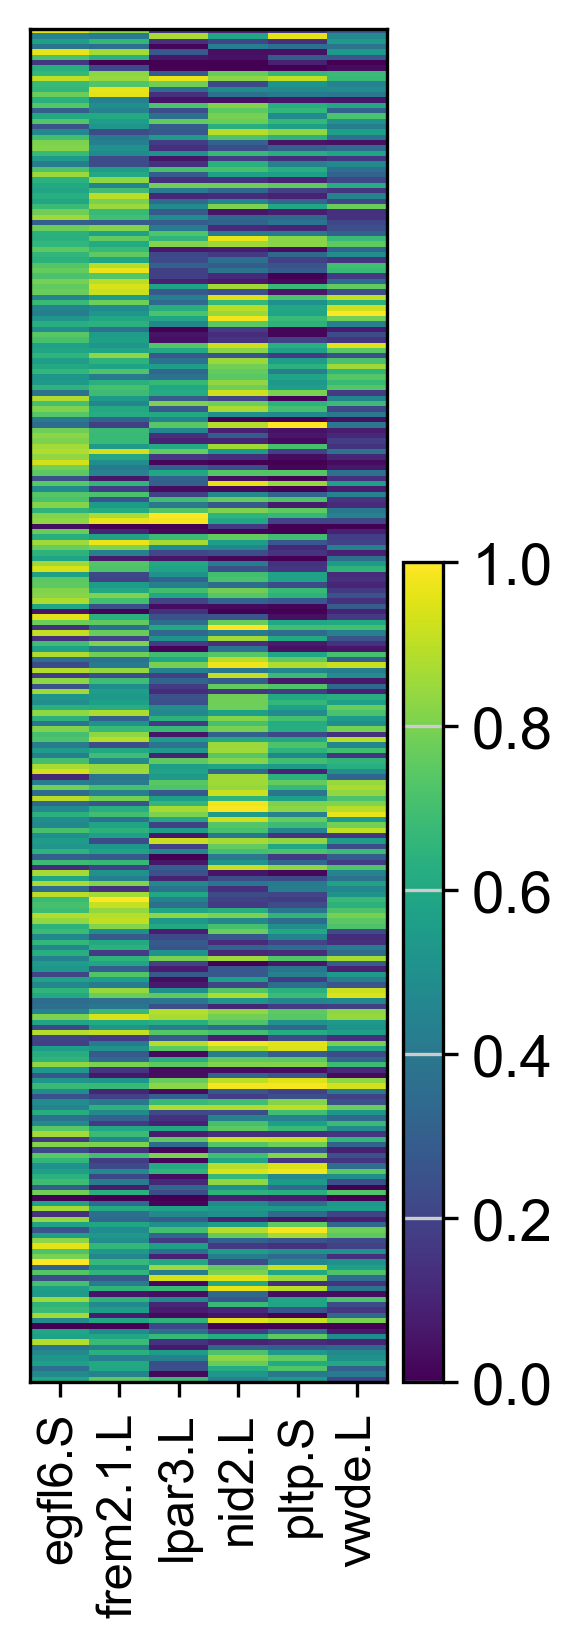

In [94]:
plot_marker_heatmap(adata, target_genes=['egfl6', 'frem2', 'lpar3', 'nid2', 'pltp', 'vwde'])

Heatmap saved to results/heatmap_com_genes.png


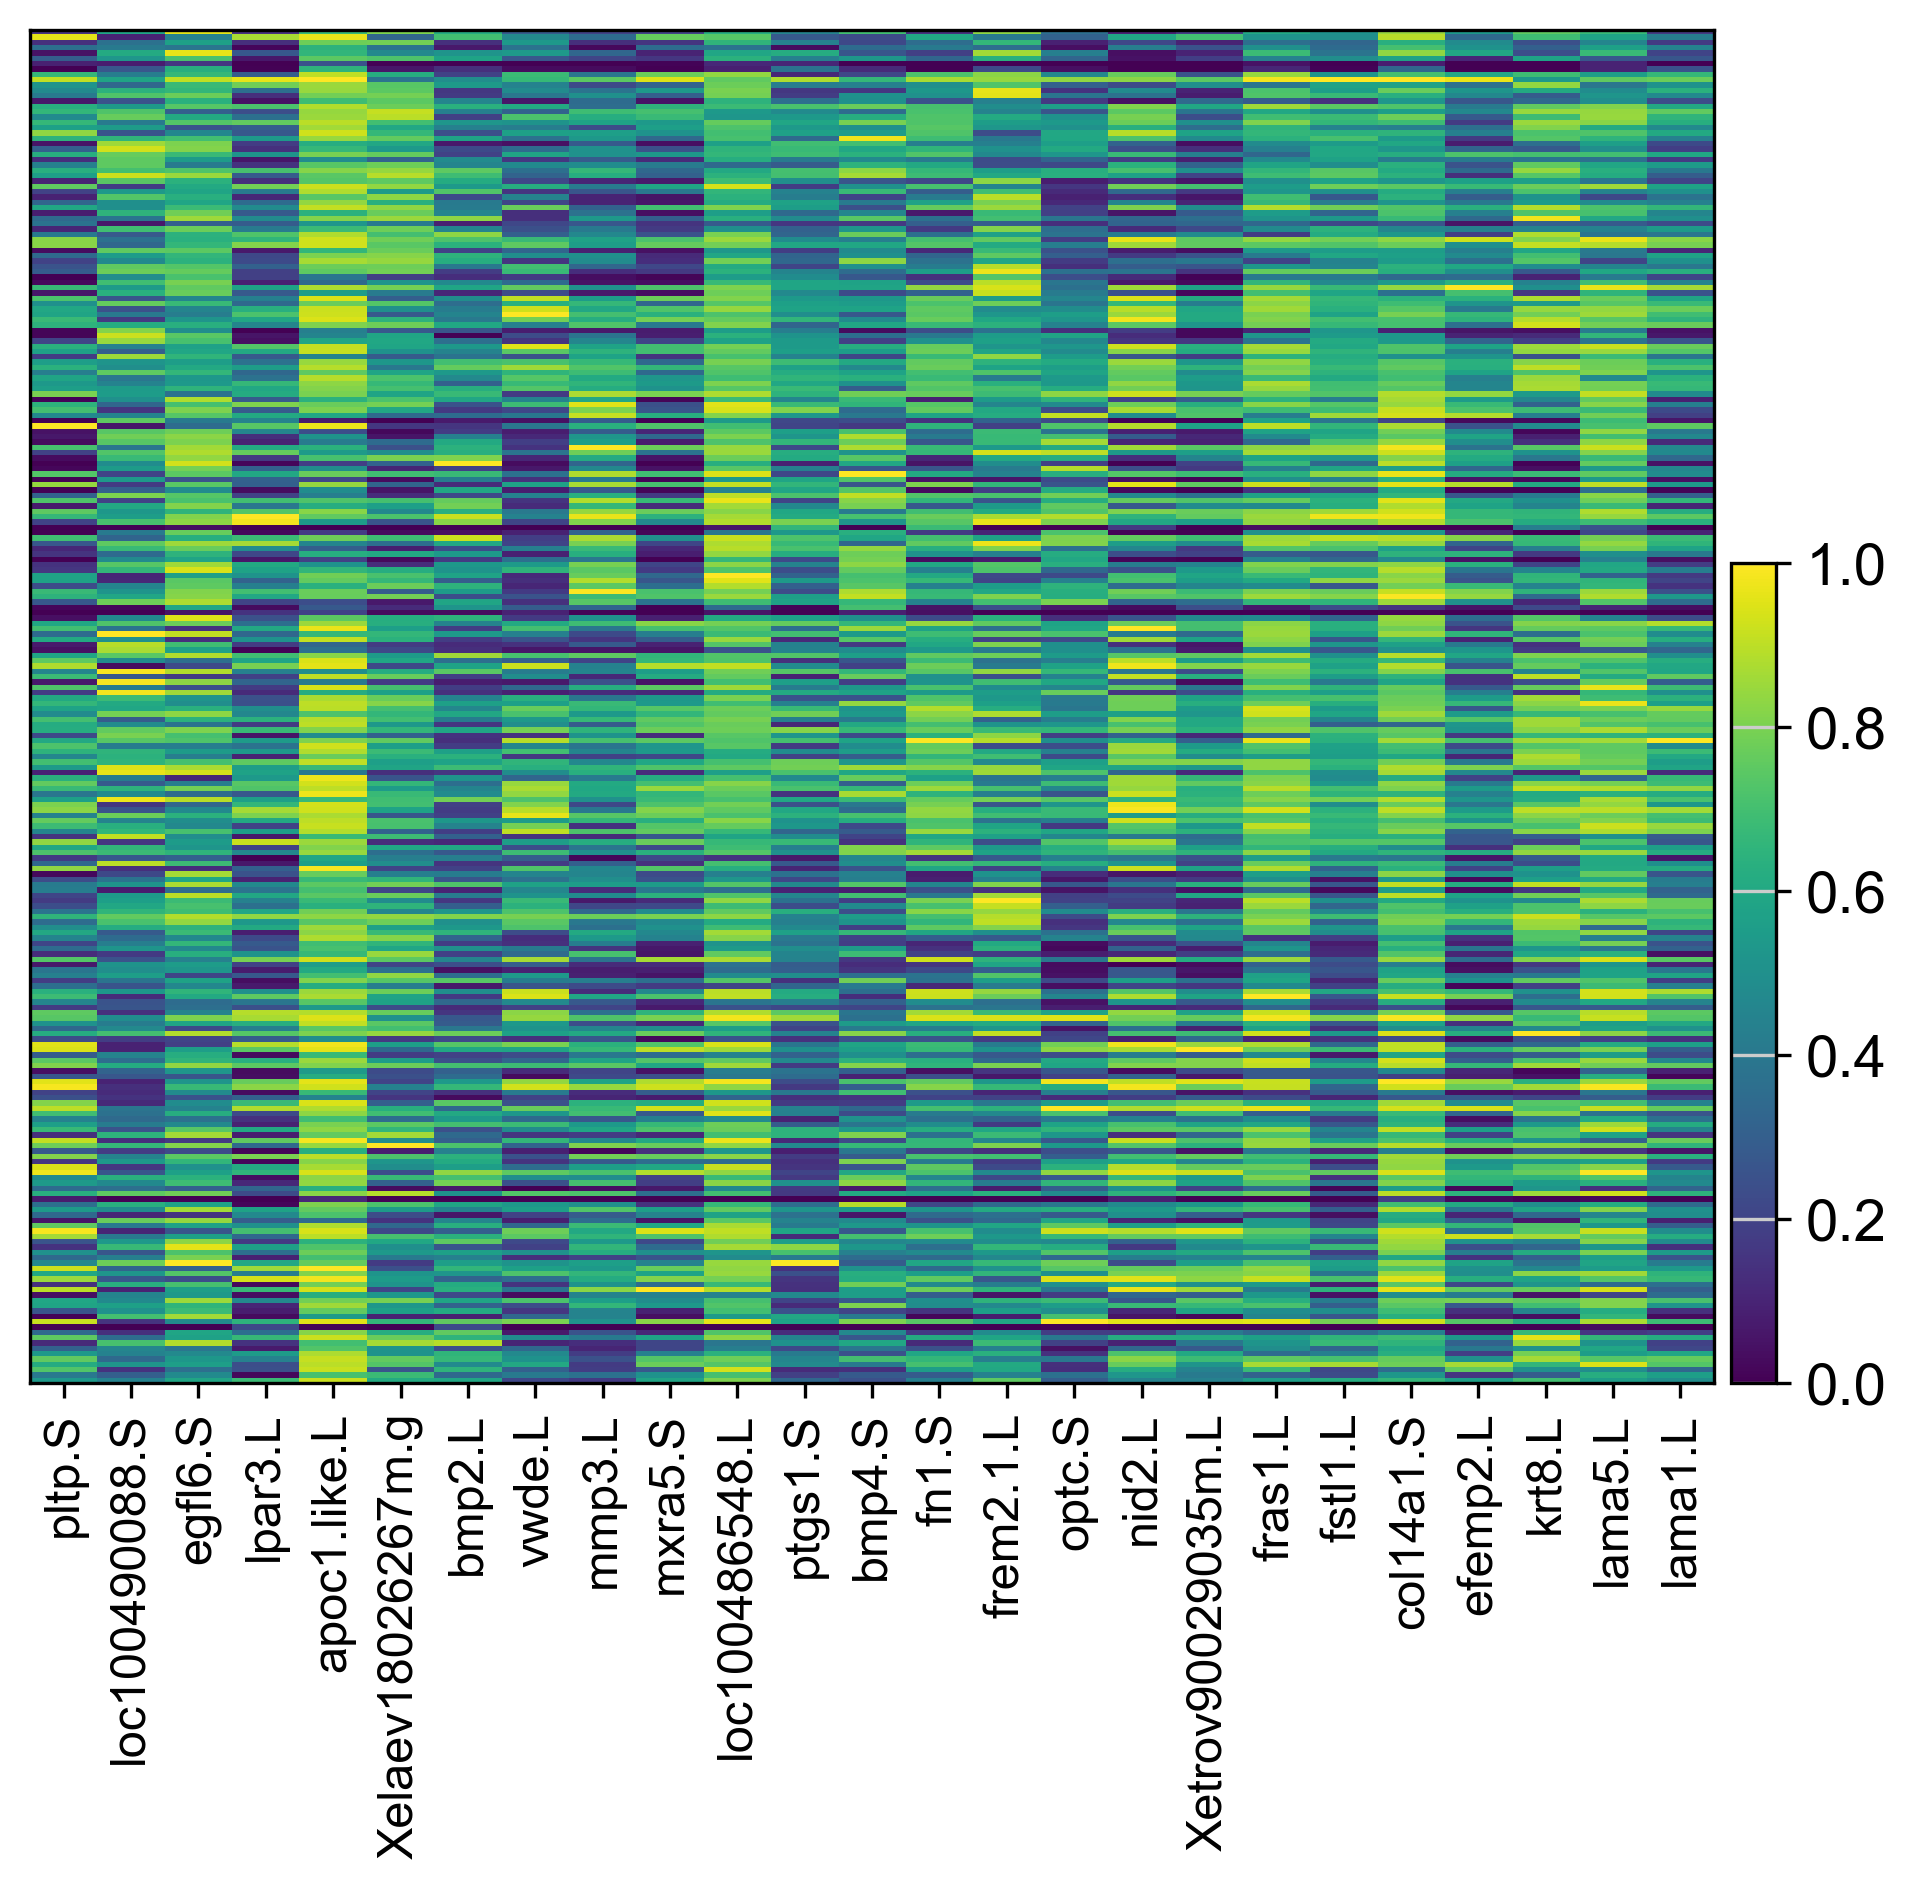

In [96]:
plot_marker_heatmap(adata, target_genes=list(global_inter))

In [28]:
!pip3 install gseapy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 537 kB 7.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [29]:
import gseapy as gp
def run_go_enrichment(gene_list, output_dir=".", organism='Xenopus', max_p=0.05, tag = ""):
    print("Start GO:")
    gene_list_upper = [g.upper() for g in gene_list if isinstance(g, str)]
    try:
        enr = gp.enrichr(gene_list=gene_list_upper,
                         gene_sets=['GO_Biological_Process_2021', 'GO_Molecular_Function_2021'],
                         organism='human',
                         cutoff=max_p)

        fn = os.path.join(output_dir, f"go_enrichment_results{tag}.xlsx")
        with pd.ExcelWriter(fn) as writer:
            for term, df in enr.results.items():
                df.to_excel(writer, sheet_name=term[:30], index=False)
        print(f"GO Finished, Result Saved: {fn}")
    except Exception as e:
        print(f"GO Failed: {e}")

/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [30]:
if global_inter:
  run_go_enrichment(list(global_inter), output_dir=output_dir)
else:
  print("No common marker genes，Skip GO!")

Start GO:
GO Finished, Result Saved: data/results/go_enrichment_results.xlsx


In [31]:
def cluster_marker(adata, methods=['logreg', 'wilcoxon'], n_markers=100, tag=""):
  extract_dir = "data"
  output_dir = "results"
  supp_table_path = os.path.join(extract_dir, "aav9996_tables3.xlsx")
  # Gene Marker
  supp_genes = load_supp_table_3(supp_table_path)
  marker_results = find_marker_genes(adata=adata, methods=methods, n_markers=n_markers)
  marker_results_clean = clean_gene_names(marker_results)
  global_inter, comp_df, venn_data = compare_markers_with_supp(marker_results_clean, supp_genes, output_dir, tag)
  if global_inter:
    run_go_enrichment(list(global_inter), output_dir=output_dir, tag=tag)
  else:
    print("No common marker genes，Skip GO!")

# Denoising

In [50]:
import anndata as ad
import scanpy as sc
extract_dir = "data/"
adata = ad.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad') # ad.read_h5ad()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

filtered out 5369 genes that are detected in less than 3 cells


In [51]:
from scipy.sparse import csr_matrix, diags
adata.X = csr_matrix(adata.X)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [52]:
#sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

W = adata.obsp['connectivities'].tocsr()
degree = np.array(W.sum(axis=1)).flatten()
degree[degree == 0] = 1
D_inv = diags(1 / degree)  
P = D_inv.dot(W) 

X = adata.X.tocsr()
X_smooth = P.dot(X)
X_smooth = (0.5 * X_smooth + 0.5 * X).tocsr()

adata.layers["smoothed"] = X_smooth
adata.X = X_smooth

computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:02)


In [53]:
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [68]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, random_state=42)

computing PCA
    with n_comps=50
    finished (0:00:52)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:02)


In [69]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=46, random_state=42)
adata.obs['kmeans'] = kmeans.fit_predict(adata.obsm['X_pca']).astype(str)

In [86]:
sc.tl.louvain(adata, resolution=1.8, key_added="louvain")

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [87]:
sc.tl.leiden(adata, resolution=1.05, key_added="leiden")

running Leiden clustering
    finished (0:00:02)


In [72]:
sc.tl.umap(adata, min_dist=0.3, random_state=42)

computing UMAP
    finished (0:00:07)


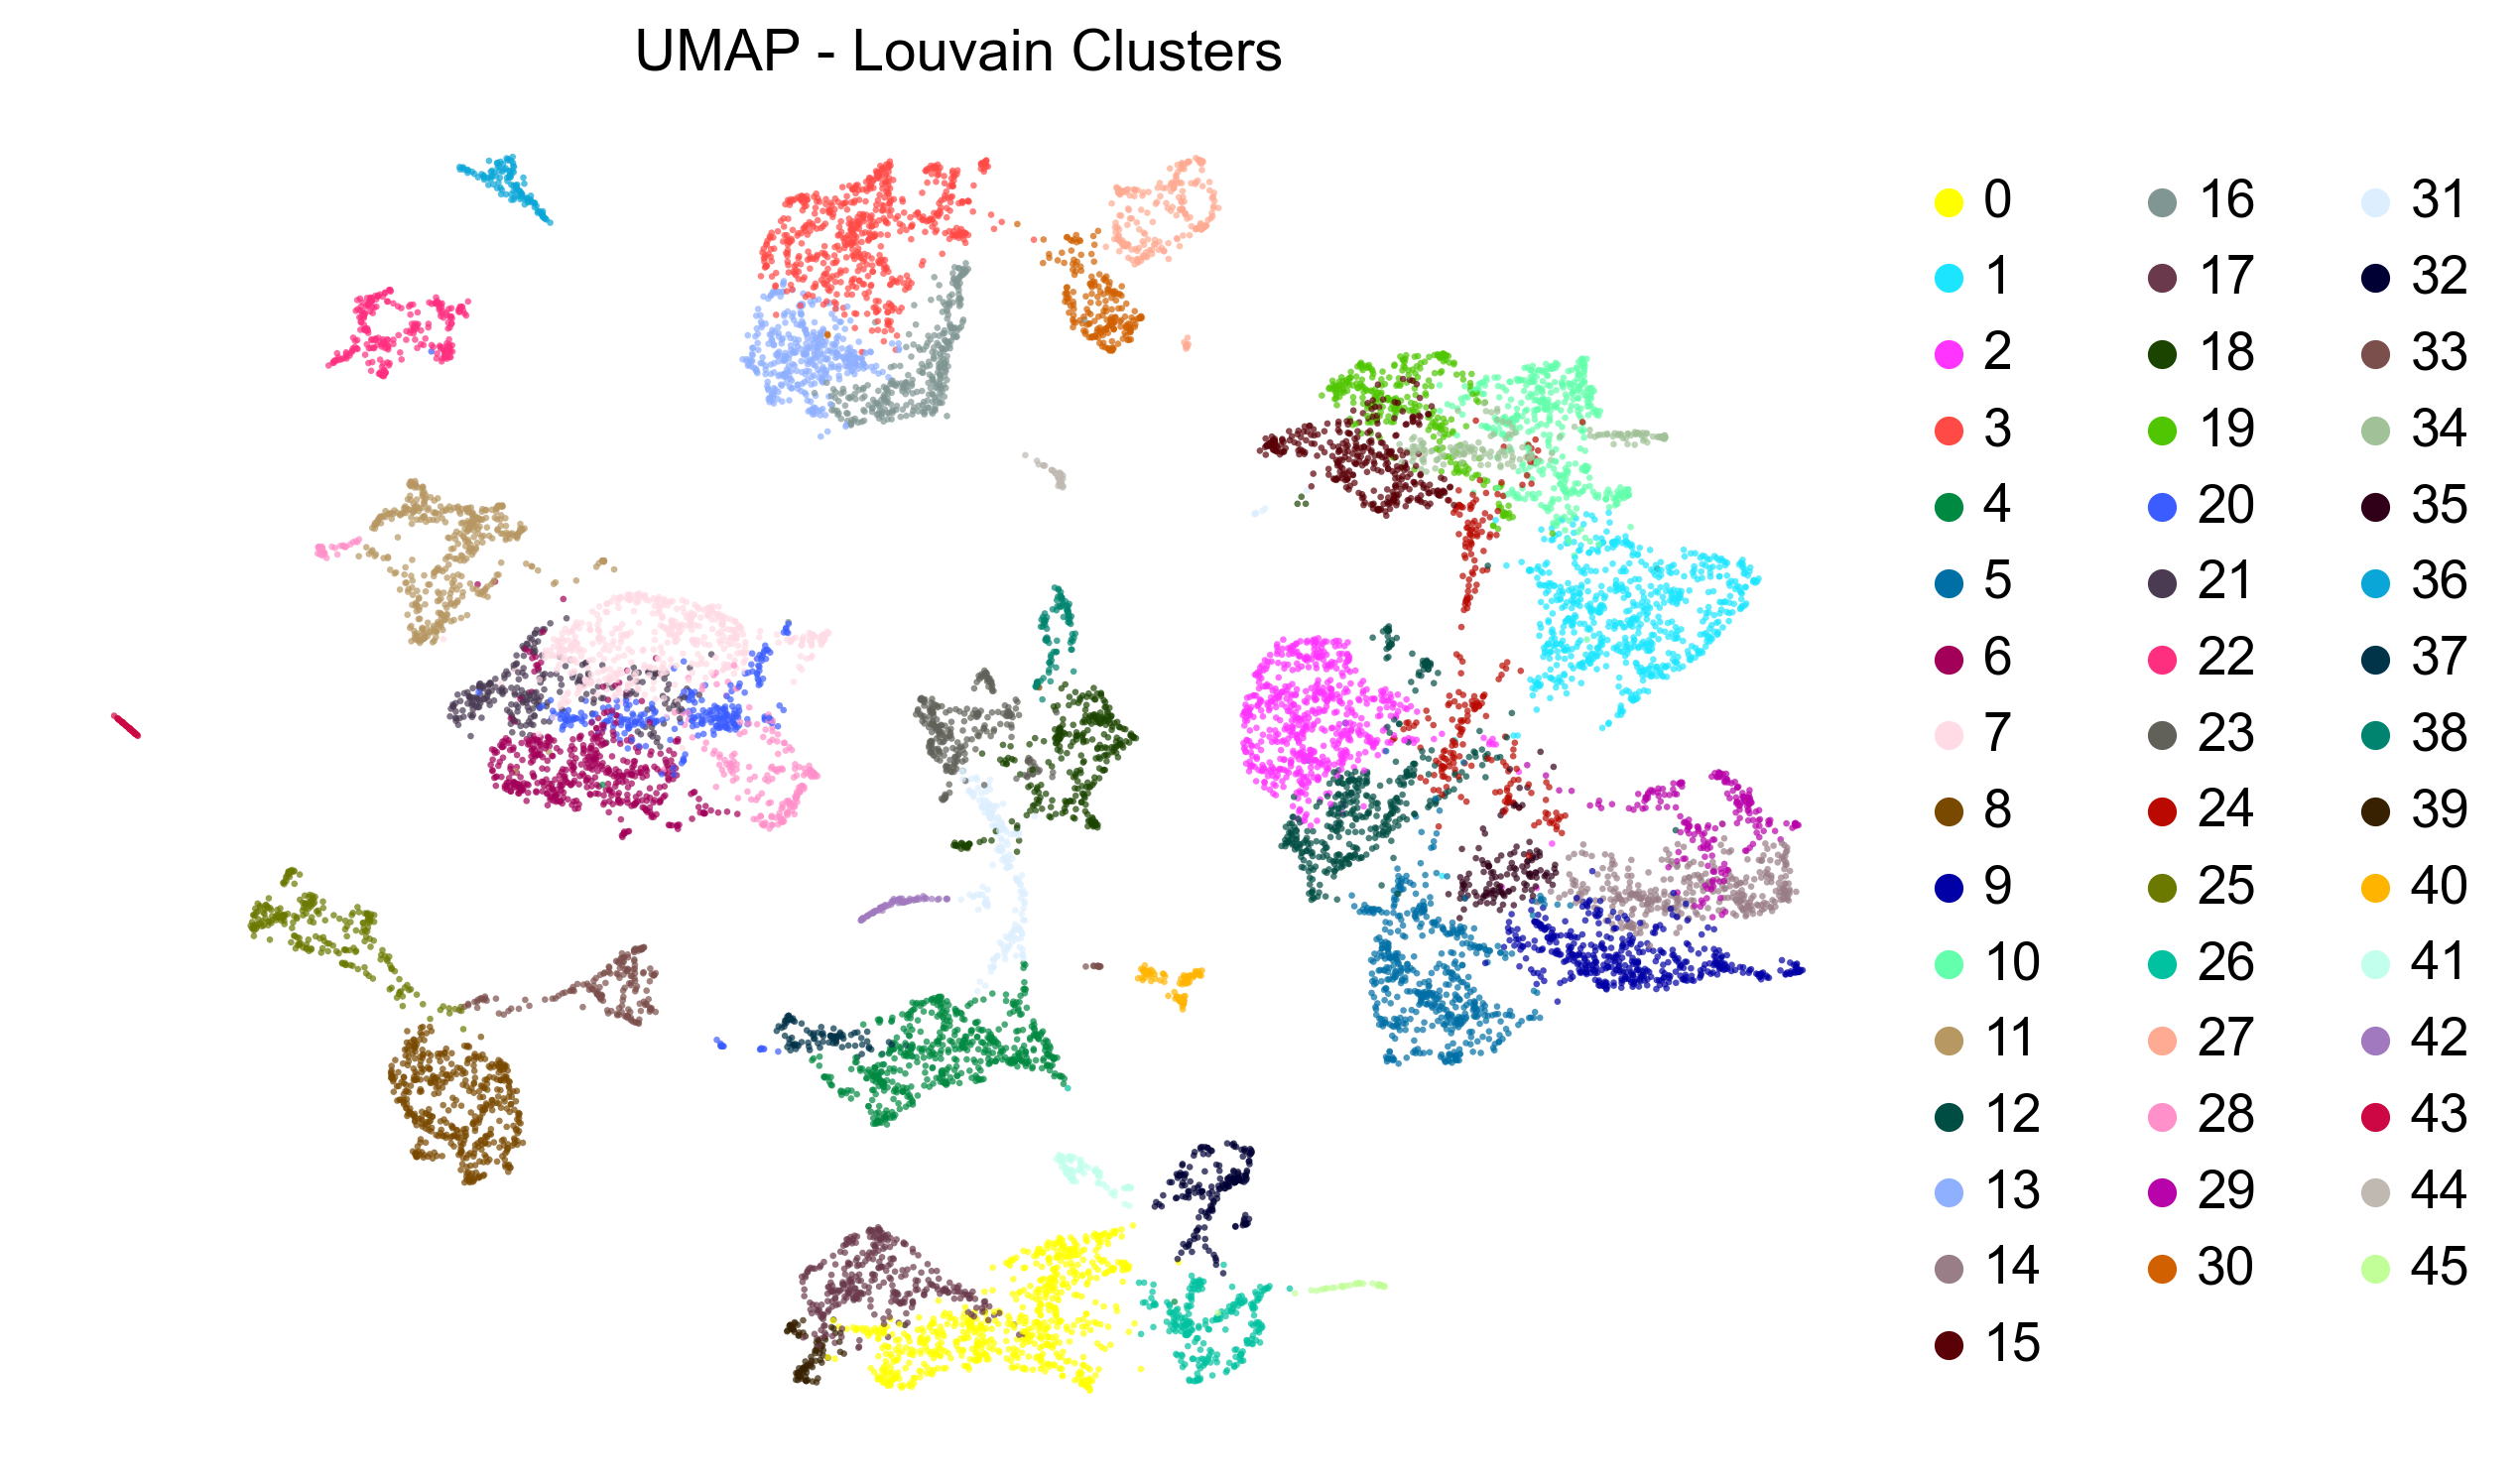

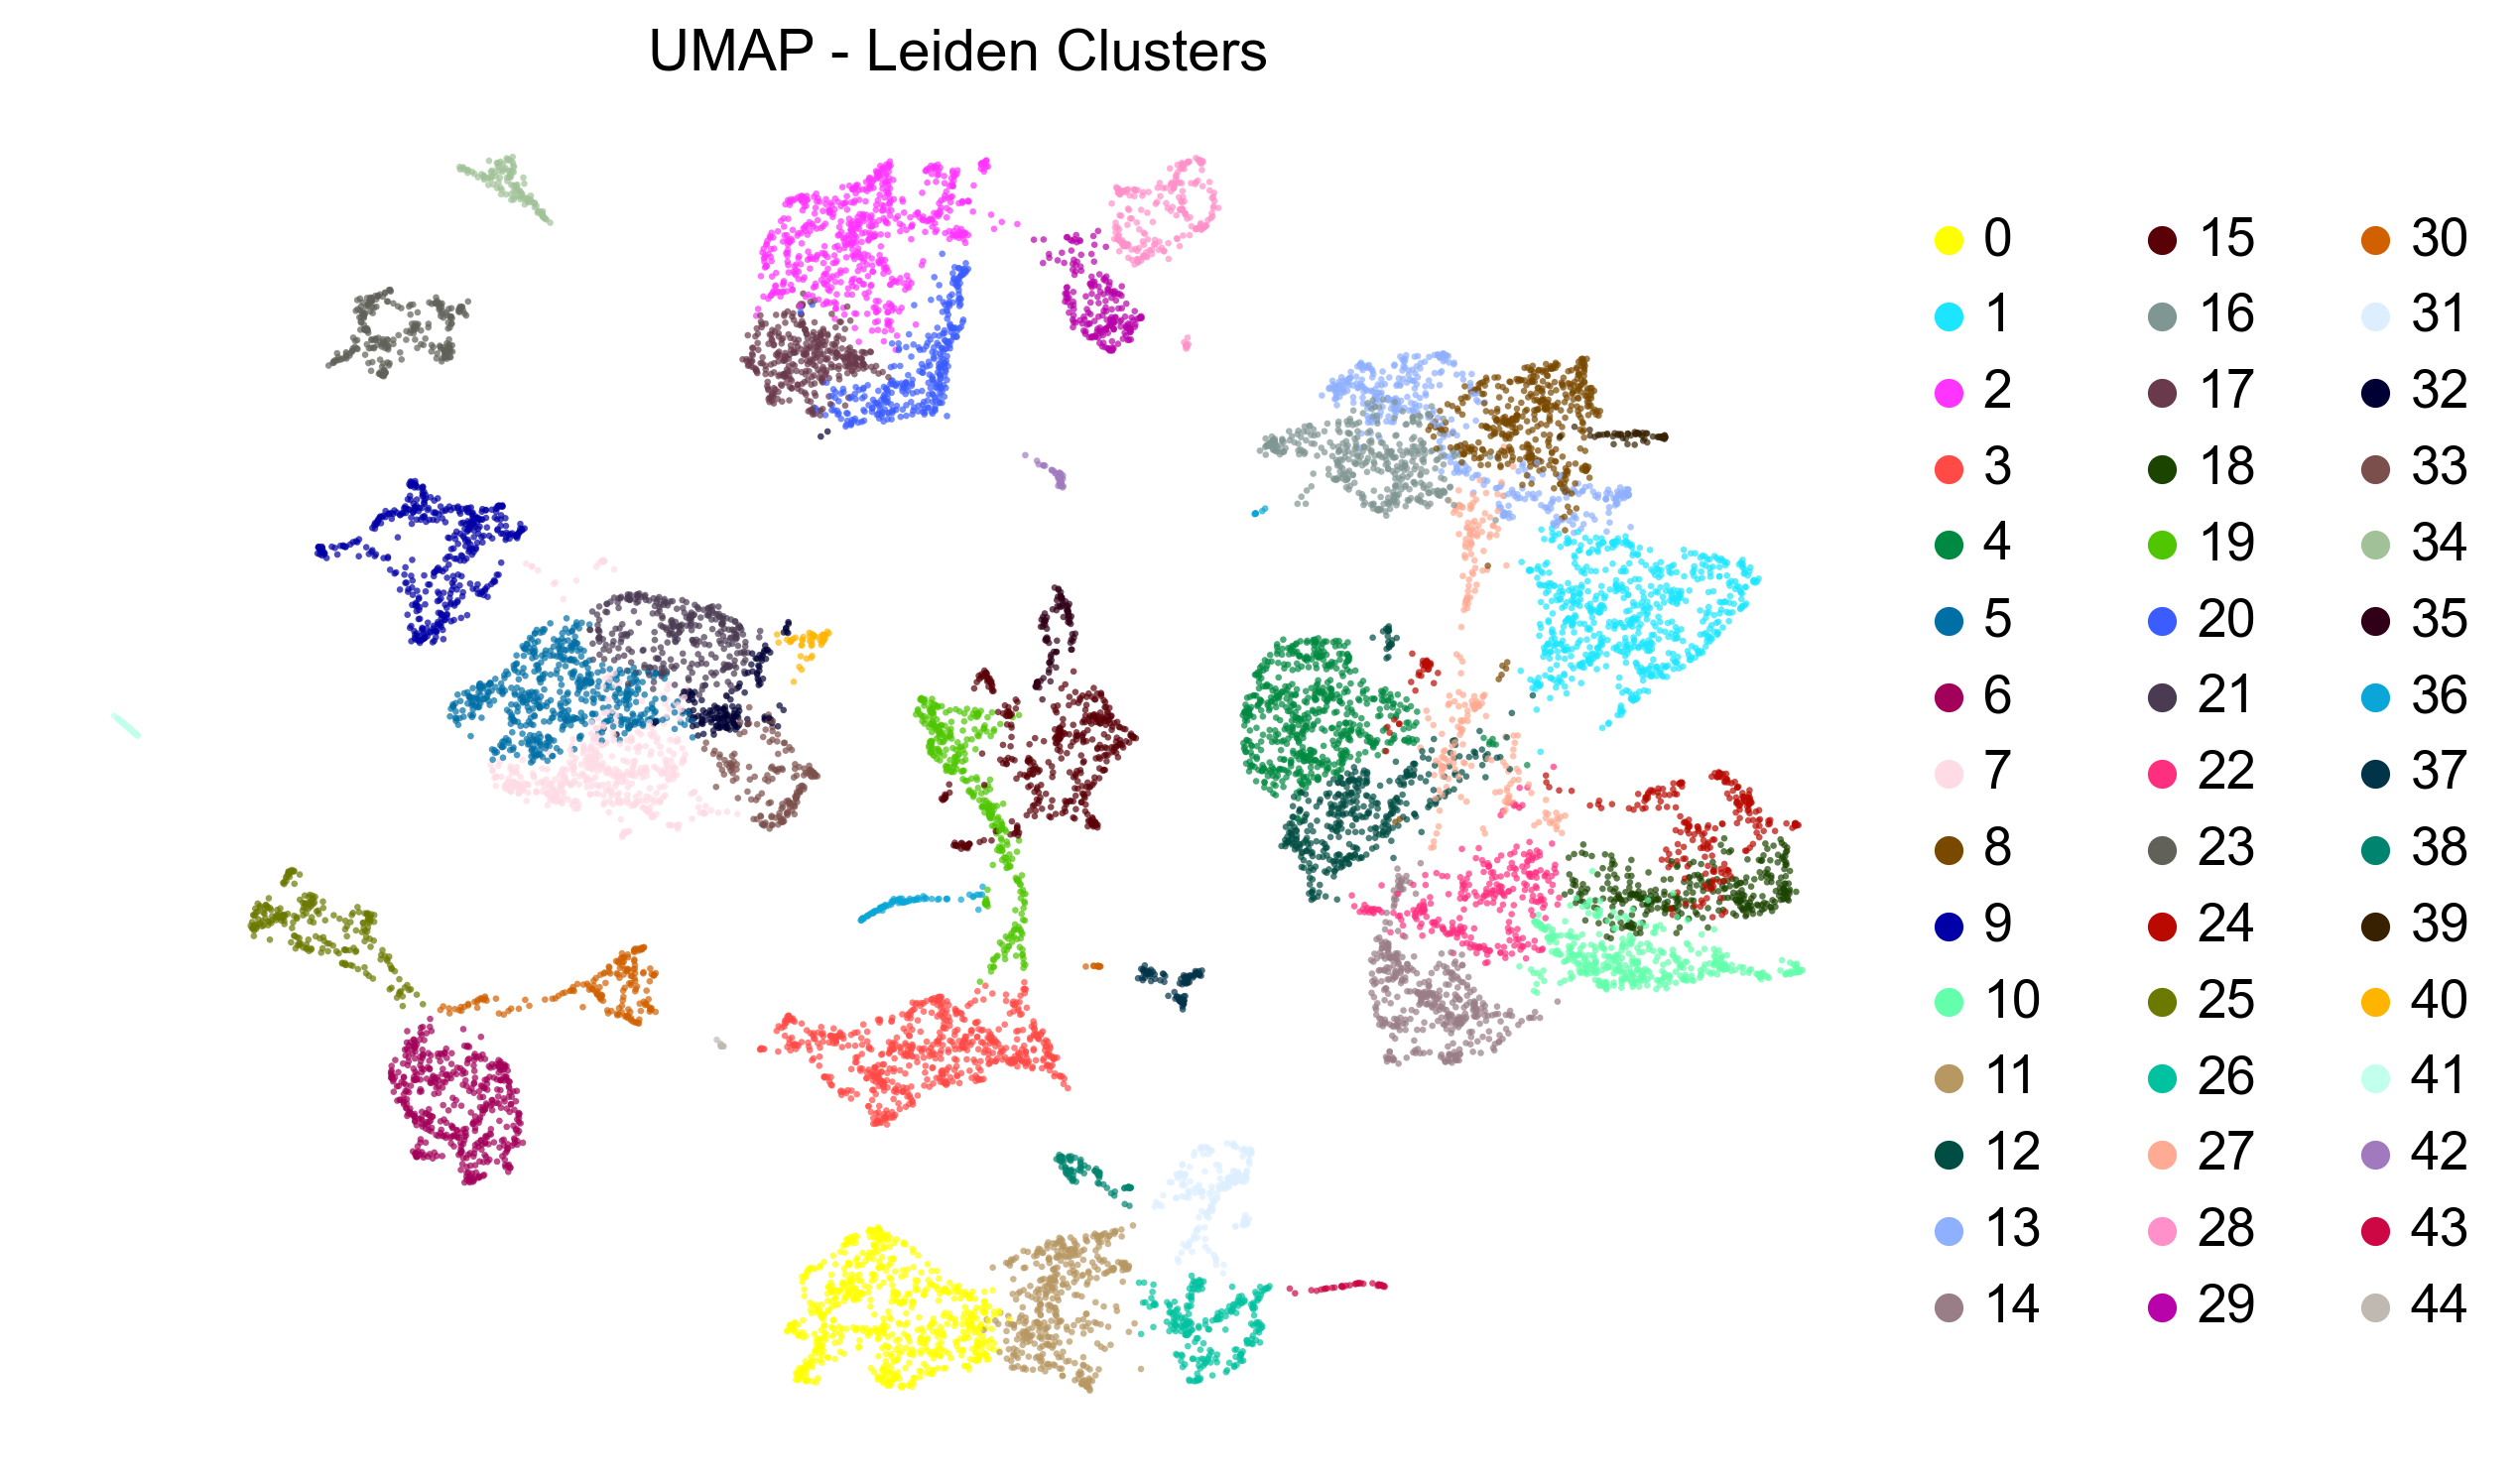

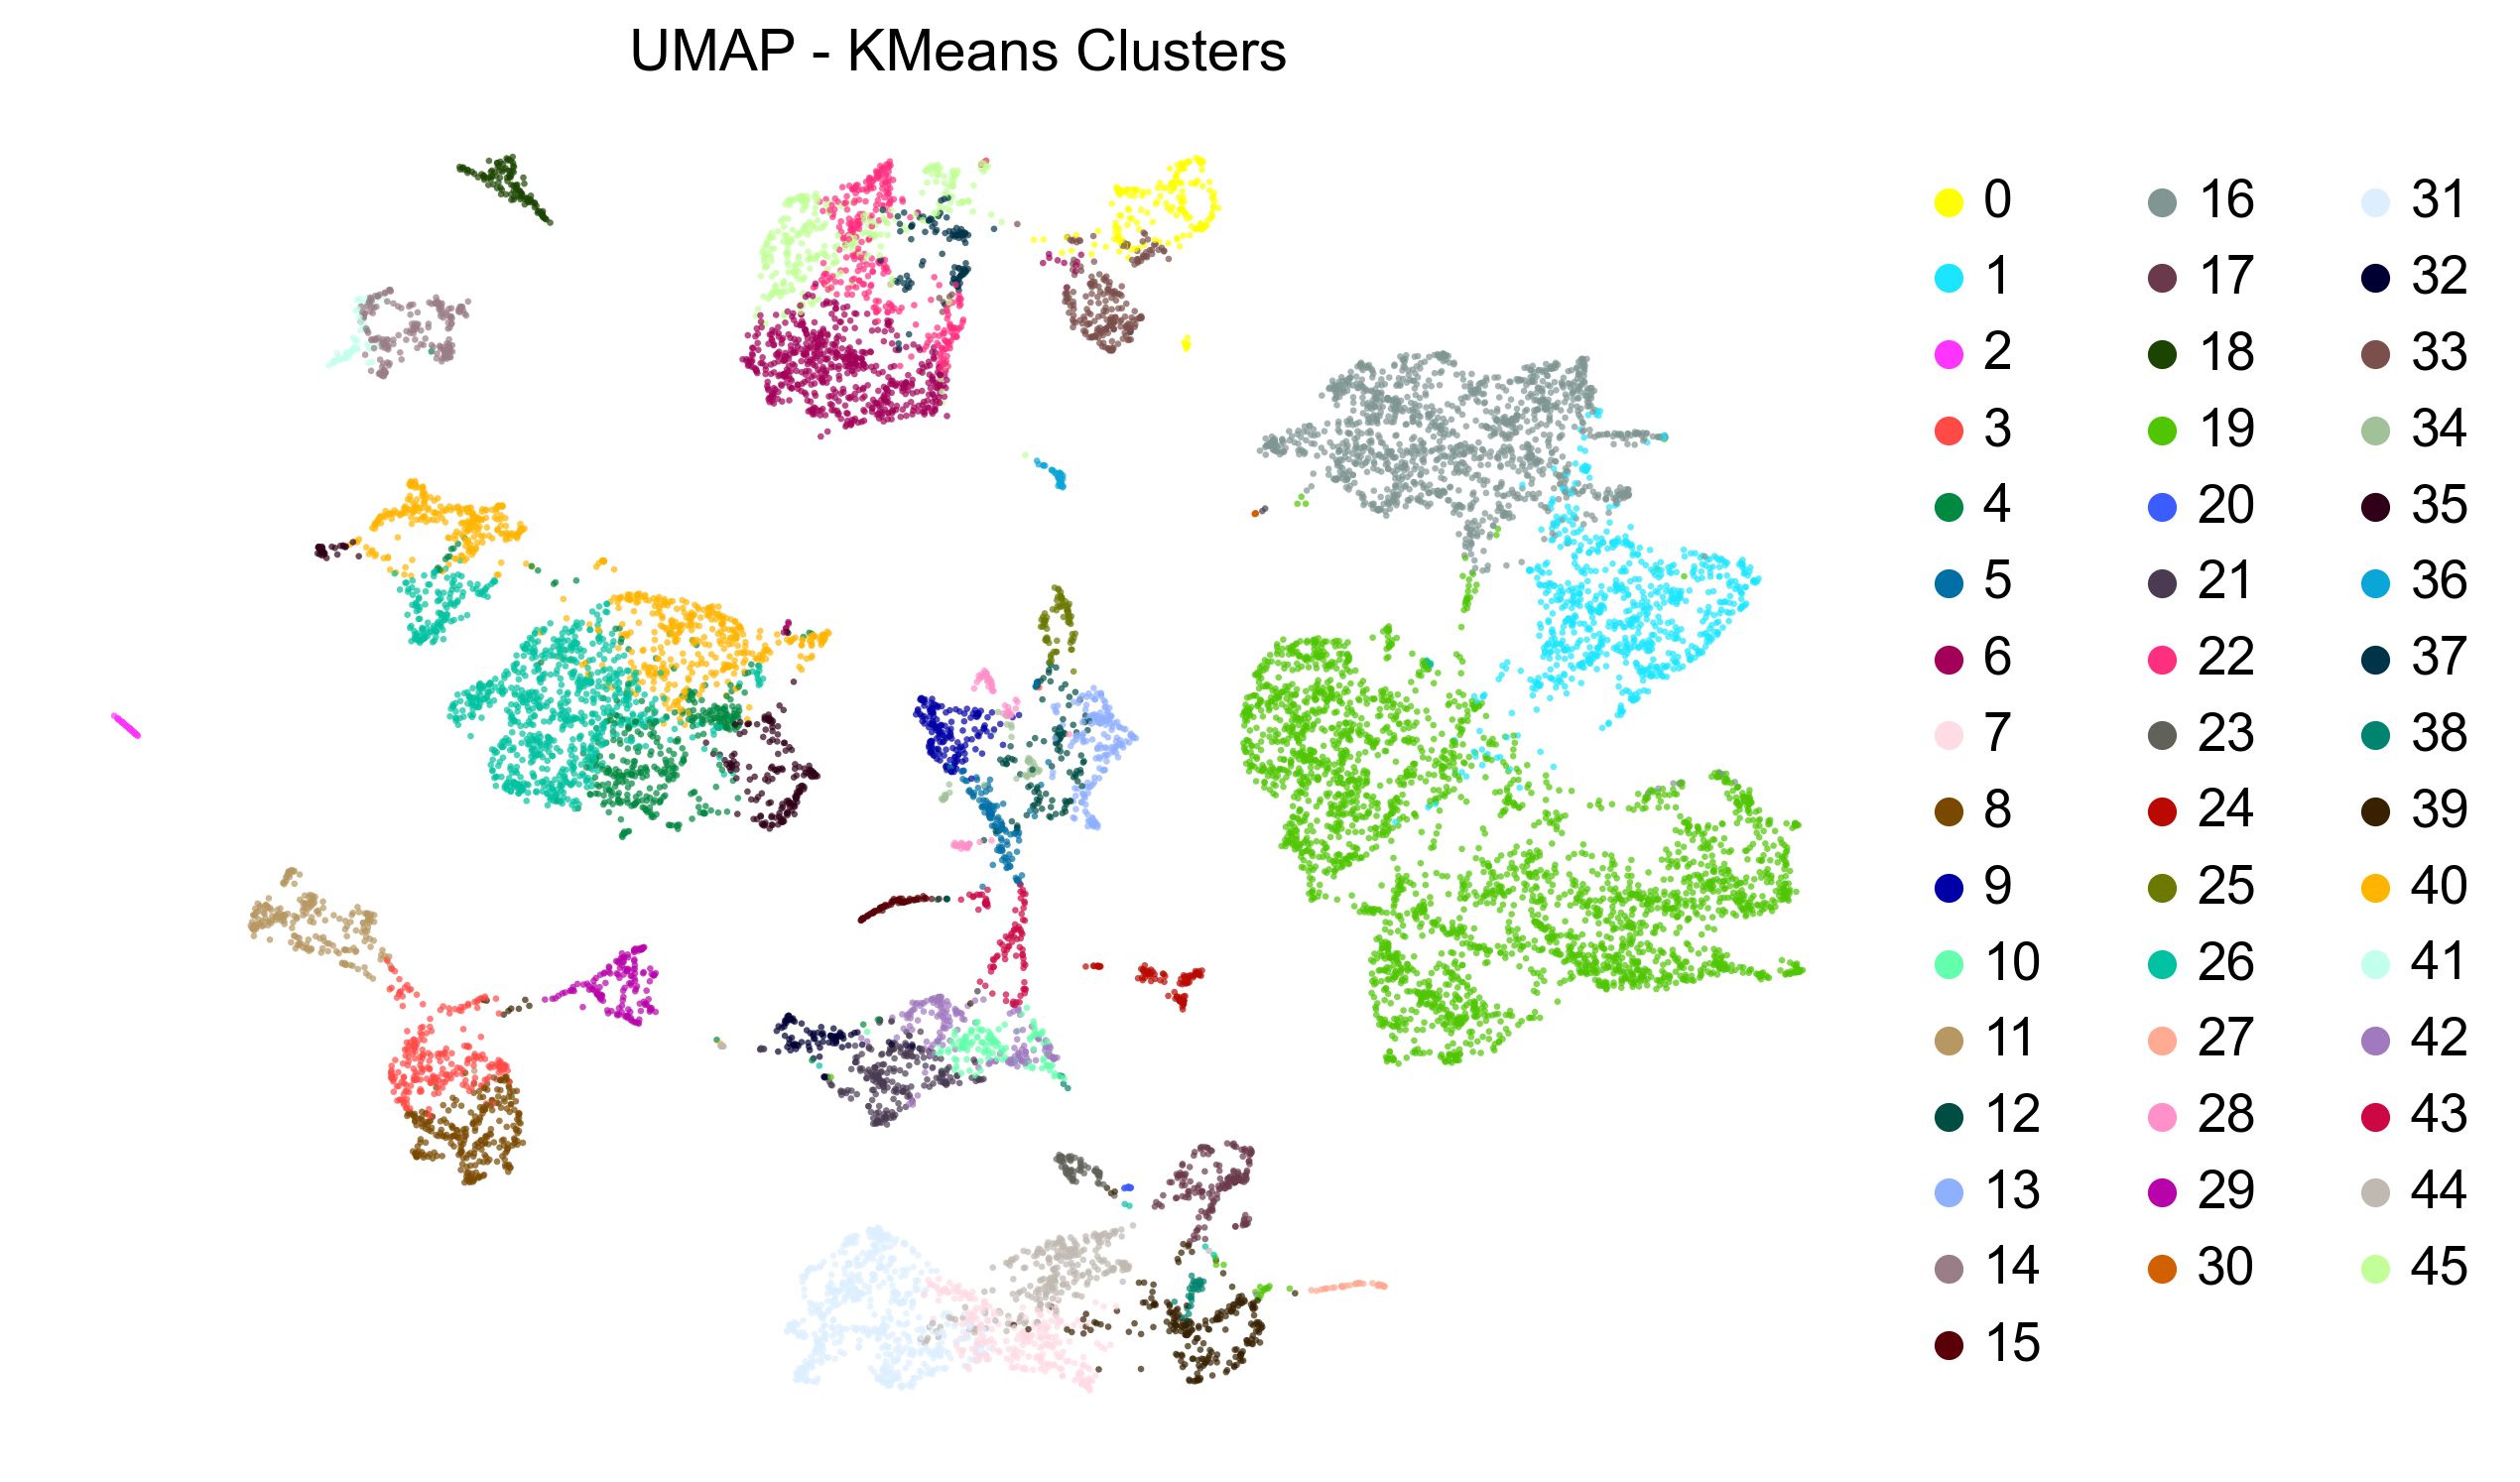

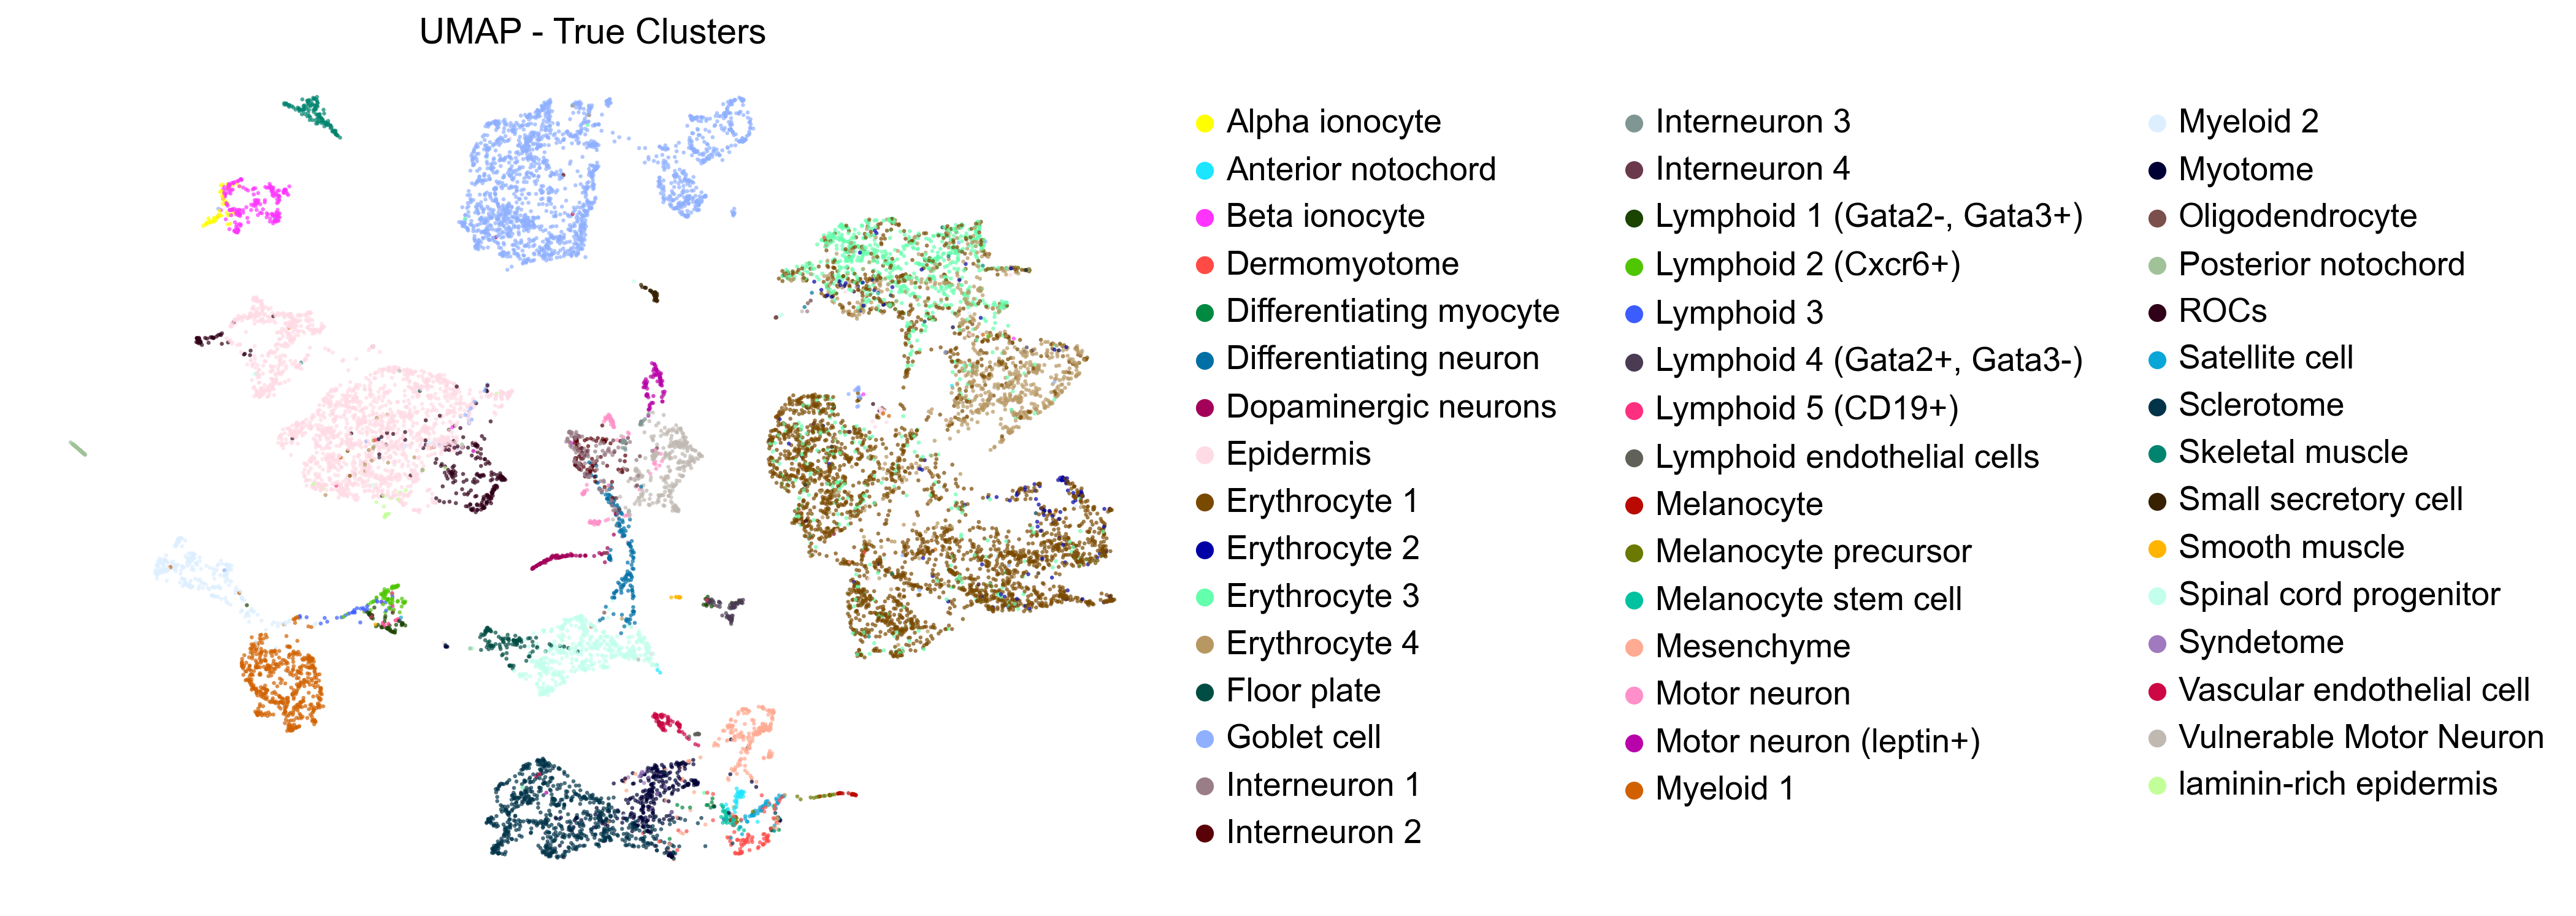

In [88]:
visualize_cluster(adata, is_show=True)

In [90]:
cluster_marker(adata, methods=['logreg', 'wilcoxon'], n_markers=100, tag="combat")

# of genes in Supplementary Table 3: 50 
# of unique genes in Supplementary Table 3: 45 
Finding markers for 'ROCs' using logreg...
ranking genes
    finished (0:01:08)
Finding markers for 'ROCs' using wilcoxon...
ranking genes


/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchange

    finished (0:02:32)


/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: Da

Finished!
Results saved: results/marker_comparison_with_supp_combat.csv
Common marker genes: 27
In Supp Table 3: 19 → ['adamts18', 'cpa6', 'dlx2', 'egfl6', 'fbn2', 'fgf7', 'fgf9', 'fgfr4', 'frem2', 'gdf6', 'jag1', 'loc100493805', 'lpar3', 'nid2', 'pltp', 'sp9', 'tinagl1', 'unc5b', 'vwde']
Start GO:
GO Finished, Result Saved: results/go_enrichment_resultscombat.xlsx
